somatic değişkenini en iyi açıklayan değişkenler hangileri? 

In [1]:
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt 

df = pd.read_csv("final_learning_potential_dataset.csv")

print(df.shape)
df.head()

(427, 7)


,stress_congeneric_score,control_congeneric,self_efficacy_congeneric,depression_congeneric_score,somatic_congeneric,cog_affect_congeneric,learning_potential_score
0,-0.994499,0.568381,1.568341,-0.852725,-1.522905,-0.294627,2.153331
1,-1.601830,1.258011,1.846971,-1.430514,-1.403349,-1.390766,3.369578
2,0.183967,-0.516081,0.397377,-0.347319,0.019725,-0.594503,0.234547
3,0.419527,-0.581236,-0.063644,-0.825759,-1.003940,-0.594503,0.534051
4,-1.093718,1.413048,0.214986,0.870991,1.372580,0.501635,-0.020603


predictors ve target seçimi 

In [3]:
target_col = "somatic_congeneric"

predictor_cols=  [
    "stress_congeneric_score",
    "control_congeneric",
    "self_efficacy_congeneric",
    "depression_congeneric_score",
    "cog_affect_congeneric"
]

6 değişkenli PCA ile hesaplandığı için data leakage sebebiyle learning_potential_score, predictors bünyesine alınmadı 

In [4]:
model_df = df[[target_col] + predictor_cols].dropna()

X = model_df[predictor_cols]
y = model_df[target_col]

X.head(), y.head()
X.shape, y.shape

((427, 5), (427,))

In [5]:
# train test ayrımı 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((341, 5), (86, 5), (341,), (86,))

In [6]:
from sklearn.metrics import r2_score, mean_squared_error

ols_model = LinearRegression()

ols_model.fit(X_train, y_train)

y_pred = ols_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

r2, mse


(0.9969829171258514, 0.003423983253678735)

In [7]:
coeff_df = pd.DataFrame({
    'predictor': predictor_cols,
    'coefficient': ols_model.coef_
})

coeff_df


,predictor,coefficient
0,stress_congeneric_score,-0.121481
1,control_congeneric,-0.089748
2,self_efficacy_congeneric,-0.039370
3,depression_congeneric_score,2.163663
4,cog_affect_congeneric,-1.234639


OLS MODELİ KATSAYI ANALİZİ VE İLK BULGULAR 

Özellikle 2 değişkenin katsayısının çok yüksek olduğu görülmüştür: 
- **depression_congeneric_score → β = +2.16**
- **cog_affect_congeneric → β = –1.23**

Tüm değişkenler ve hedef z-score formatında olduğundan, bu katsayılar **standardize edilmiş etki büyüklüğü** olarak yorumlanabilir. Bu açıdan:
-depresyon puanındaki 1 standart sapmalık artış, somatik şikayetlerde 2.16 standart sapmalık bir artış ile, 
-kognitif efektif puanındaki 1 standart sapmalık artış ise somatik şikayetlerde 1.23 standart sapmalık bir azalma ile ilikşilendirilir.

Bu büyüklükteki katsasyılar psikoloji literatüründe çok güçlü etki kabul edilmektedir 

Bu bulgu 2 noktayı işaret etmektedir:

1- **Shared Variance /*Yüksek Ortak Varyans***
Tüm congeneric skorlar aynı kişiden, aynı oturumda benzer psikolojik içerklerle ölçülmüştür. Bu nedenle depresyon ve kognitif efekt ile somatik arasında yüksek derecede örtüşen psikolojik yapı bulunmaktadır. 

2- **Multicollinearity /*Çoklu Doğrusal Bağlantı***
Predictor'ların birbirine yüksek derecede benzediği durumlarda OLS katsayıları şişebilir, model narin hale gelebilir ve katsayılar gerçek etkilerinden sapabilir. 

Bu sebeple OLS modeli yalnızca baseline olarak değerlendirilmiştir.
OLS sonrasında model varsayımlarını ve katsayı stabilitesini değerlendirmek amacıyla diagnostic analizler (correlation matrix, VIF, residual diagnostics) uygulanacaktır.
Bu analizler, veri setinin shared-variance / multicollinearity seviyesini incelemek ve katsayıların güvenilirliğini değerlendirmek için gereklidir.
Diagnostic sonuçlarına göre, katsayıların stabilitesini artırmak ve aşırı şişme (coefficient inflation) etkisini azaltmak amacıyla Ridge ve Lasso regresyon modellerine geçilecektir.

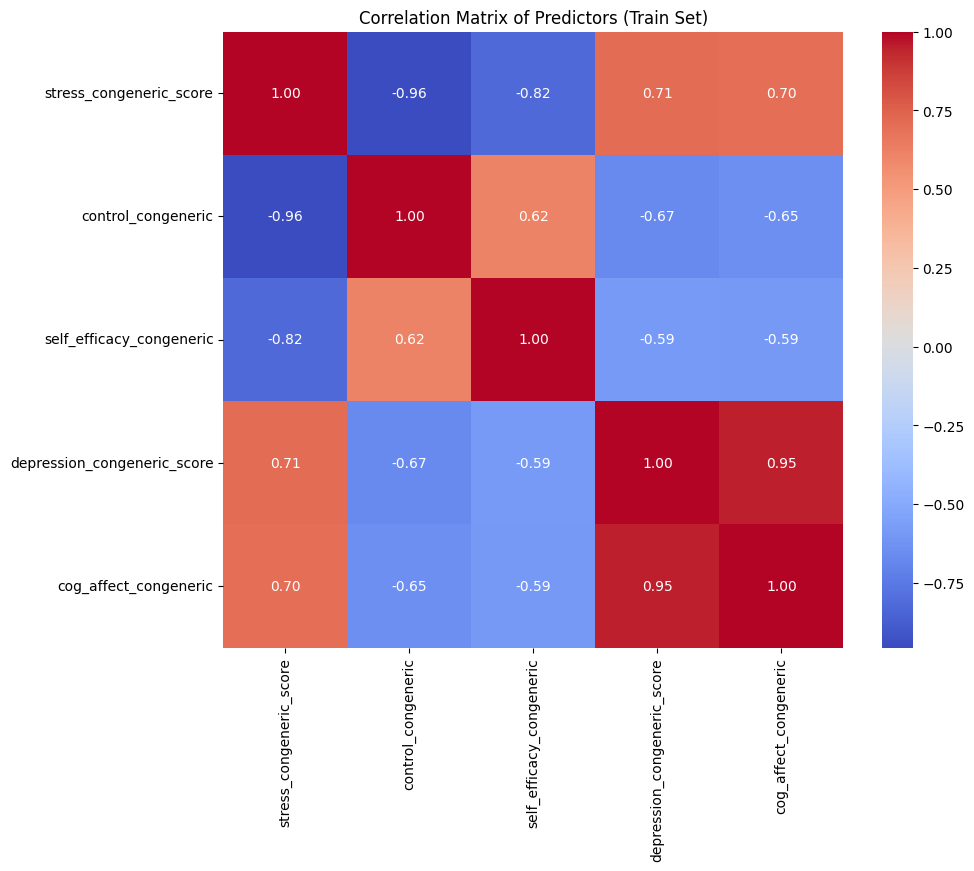

In [8]:
#diagnostic 1: corr matrix

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Predictors (Train Set)")
plt.show()

korelasyon haritası bize yüksek r2 değerini açıklamada yardımcı oluyor; predictor'lar arasında çok güçlü yüksek ortak varyans ve yüksek korelasyon olduğunu görüyoruz. 

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = X_train.copy().reset_index(drop=True)

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]
 
vif_data

,feature,VIF
0,stress_congeneric_score,760.219148
1,control_congeneric,396.080216
2,self_efficacy_congeneric,104.649039
3,depression_congeneric_score,10.959974
4,cog_affect_congeneric,10.631272


Tablo bize gösteriyor ki tüm değişkenler son derece multi kolineer; lakin bu veri seti için bu sonuç beklenen bir durumdur ve tek başına bir hata işareti değildir. 
Ölçtüğümüz değişkenler literatürde de doğal olarak birlikte değişen, yüksek ortak varyans taşıyan yapılardır. Bu yüzden birbirlerini güçlü şekilde açıklamaları son derece normaldir.

Ancak; multi konilerliğin bir sonucu olarak **OLS katsayıları kararsız ve yorumlanamaz hale gelir**. Katsayıların büyükülüğü, yönü veya sıfıra yakınlığı güvenilir değildir. 

Sonuç;
Bu veri yapısında OLS modeli katsayı yorumu için uygun değildir.
Tutarlı katsayılar elde etmek ve multicollinearity’nin etkisini azaltmak için Ridge ve Lasso gibi düzenlileştirilmiş regresyon modellerine geçmek gereklidir.

In [ ]:
#Rıdge 

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold 

alpha_values = np.logspace(-3, 3, 30) 

cv_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for alpha in alpha_values:
    model = Ridge(alpha=alpha) 

    fold_scores = []
    for train_index, val_index in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        fold_scores.append(r2_score(y_val, preds))

    cv_scores.append(np.mean(fold_scores))    

best_alpha = alpha_values[np.argmax(cv_scores)]    
best_alpha

np.float64(0.04520353656360243)

In [16]:

ridge_final = Ridge(alpha=float(best_alpha))
ridge_final.fit(X_train, y_train)

y_pred_ridge = ridge_final.predict(X_test)

r2 = r2_score(y_test, y_pred_ridge)

mse = mean_squared_error(y_test, y_pred_ridge)

r2, mse

(0.997014712083573, 0.0033879002532008103)

In [17]:
pd.Series(ols_model.coef_, index=X_train.columns)


stress_congeneric_score       -0.121481
control_congeneric            -0.089748
self_efficacy_congeneric      -0.039370
depression_congeneric_score    2.163663
cog_affect_congeneric         -1.234639
dtype: float64

In [18]:
pd.Series(ridge_final.coef_, index=X_train.columns)


stress_congeneric_score       -0.105700
control_congeneric            -0.078874
self_efficacy_congeneric      -0.033822
depression_congeneric_score    2.159196
cog_affect_congeneric         -1.230585
dtype: float64

##  Modelleme Yaklaşımının Revizyonu: Predictor Importance Yerine Latent Faktör Modeli

Önceki bölümlerde somatic üzerindeki etkileri anlamak için 
'stress', 'depression', 'cog_affect', 'self_efficacy', 'control' gibi ölçekleri 
tek tek modele dahil ederek bireysel katsayılardan “predictor importance” ölçümü hedeflendi.

Ancak yapılan OLS, Ridge, VIF ve korelasyon analizleri sonucunda:

- Predictor’lar arasında aşırı yüksek shared variance olduğu,
- VIF değerlerinin 100–700 aralığında olduğu,
- Katsayıların modelden modele stabil olmadığını,
- OLS ve Ridge sonuçlarının yorumlanabilir etki büyüklükleri üretemediğini,
- Ölçeklerin aslında tek bir ortak psikolojik yapının yüzleri olduğu
tespit edildi.

Bu nedenle bu veri seti, bağımsız predictor’lar arasında “Hangi değişken daha önemlidir?” sorusunu yanıtlamaya uygun bir yapıda değildir.  
Bu, veri kalitesinin değil; psikometrik yapının doğal bir sonucudur.

### Yeni Yöntem: Latent Distress Faktörü

Somatic’i açıklamak için bireysel predictor katsayıları yerine,
negatif duygulanım ölçeklerinden (`stress`, `depression`, `cog_affect`)
tek bir latent distress faktörü çıkarılacak ve somatic bu latent yapı üzerinden
modellenerek yorumlanacaktır.

Bu yaklaşım:

- Multicollinearity sorununu ortadan kaldırır,
- Yorumlanabilir ve psikolojik olarak anlamlı bir model kurar,
- Literatürdeki *“general distress / negative affect core”* yapısına karşılık gelir,
- Somatic’i etkileyen ortak çekirdeği (core factor) yakalar.

Bu noktadan itibaren modelleme, latent distress -> somatic ilişkisini ele alacaktır
ve predictor importance hedefi resmi olarak terk edilmiştir.
